In [1]:
# Program of DNN based speech quality model using 13D MFCC, 10D LSF and 22D MRAM features. 

In [2]:
# Input- 13D MFCC, 10D LSF and 22D MRAM speech features of all 960 speech samples of NOIZEUS corpus.
# Output- Subjective MOS (1 feature)

In [3]:
# Importing library

# Below four lines at top for generalization

from numpy.random import seed
seed(0)
import tensorflow
from tensorflow import keras
tensorflow.random.set_seed(0)

import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
#To show the output within the jupyter notebook itself!
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, r2_score
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA
 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, LeakyReLU, PReLU, ELU, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
# Loading speech features CSV.

df = pd.read_csv(r"Features_MRAM22_MFCC13_LSF10_with_subj_MOS_in_last_colm_NOIZEUS_960_data.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-444.570925,296.776581,18.202963,45.533201,1.642507,-15.425329,4.708653,46.790126,8.448926,15.889262,...,0.453181,0.678998,0.891810,1.230811,1.421894,1.796246,1.986595,2.309713,2.508269,1.90
1,195.424383,42.548533,-47.232038,55.060092,7.180520,18.735858,13.461191,-0.250632,7.562356,2.405553,...,0.406532,0.655776,0.960409,1.218916,1.415331,1.815550,2.011391,2.334045,2.517978,3.40
2,334.387423,-17.849127,-72.648701,82.934209,-7.990511,22.857897,9.841212,0.760615,8.922243,1.083629,...,0.384863,0.658164,0.975786,1.247341,1.422940,1.800574,2.004081,2.318268,2.518089,4.00
3,-84.540389,105.204346,-51.079037,53.362872,-3.819920,-0.333042,7.604571,10.182099,1.337922,4.478997,...,0.426488,0.681705,0.939973,1.236867,1.449592,1.802309,1.988633,2.341644,2.501178,2.60
4,-362.376360,236.886432,-116.752987,72.598387,42.287054,-6.337295,35.864093,8.531290,-2.272590,-5.680350,...,0.446047,0.641988,0.941404,1.233371,1.399887,1.803749,1.989725,2.318140,2.509942,1.85


In [5]:
# df.info()

In [6]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
count,9.600000e+02,9.600000e+02,9.600000e+02,9.600000e+02,9.600000e+02,9.600000e+02,9.600000e+02,9.600000e+02,9.600000e+02,9.600000e+02,...,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000
mean,3.583371e-10,-7.906256e-10,-8.437553e-11,-2.177084e-10,-4.062599e-11,-1.062501e-10,-7.708347e-11,6.249934e-12,-2.395808e-11,1.145833e-11,...,0.434500,0.697660,0.944261,1.250561,1.468596,1.809963,2.025972,2.352155,2.500748,2.773745
std,4.507852e+02,1.631143e+02,7.723060e+01,4.400768e+01,3.169937e+01,2.873496e+01,1.844305e+01,1.666393e+01,8.997200e+00,7.298105e+00,...,0.038750,0.045955,0.052109,0.063937,0.067317,0.048178,0.031235,0.034416,0.026125,0.692423
min,-1.746532e+03,-4.943593e+02,-2.297495e+02,-2.656343e+02,-1.642472e+02,-8.584618e+01,-6.334238e+01,-6.541378e+01,-3.141641e+01,-2.533185e+01,...,0.326657,0.570271,0.832117,1.096056,1.313909,1.658957,1.916542,2.245640,2.420407,1.250000
25%,-2.715557e+02,-1.028794e+02,-5.660745e+01,-2.802270e+01,-2.019929e+01,-1.739295e+01,-1.006815e+01,-1.008292e+01,-5.502130e+00,-5.487177e+00,...,0.406940,0.667319,0.906840,1.204903,1.420091,1.774078,2.006137,2.332330,2.484764,2.250000
50%,8.736536e+01,-7.044766e+00,7.670985e+00,-3.034007e+00,2.757891e-01,1.241361e+00,1.346281e-01,1.292174e+00,4.544658e-01,6.769125e-02,...,0.436554,0.689493,0.935696,1.245167,1.460498,1.812674,2.025960,2.351830,2.499327,2.800000
75%,3.317257e+02,1.073519e+02,5.448594e+01,2.755067e+01,2.136107e+01,1.558972e+01,9.452177e+00,1.063094e+01,6.433301e+00,5.076224e+00,...,0.458977,0.722770,0.979120,1.291627,1.510885,1.845489,2.044528,2.370632,2.515273,3.300000
max,8.094532e+02,5.760999e+02,2.860946e+02,1.741065e+02,1.765155e+02,1.435652e+02,1.103769e+02,5.884597e+01,3.492768e+01,2.707132e+01,...,0.607427,0.862913,1.123899,1.436808,1.656716,1.955867,2.149224,2.470893,2.595517,4.350000


In [7]:
df.shape # size of dataframe 

(960, 46)

#### The distplot represents the univariate distribution of data i.e. data distribution of a variable against the density distribution. It shows the histogram with a line on it.

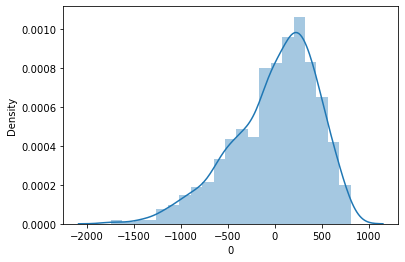

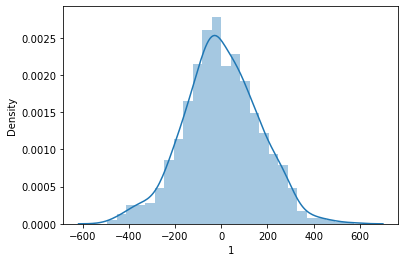

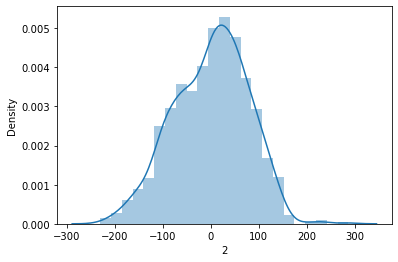

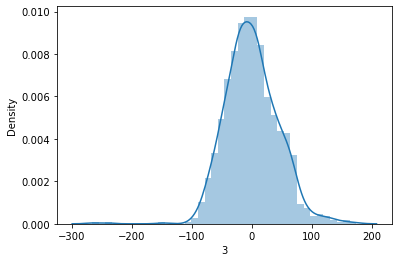

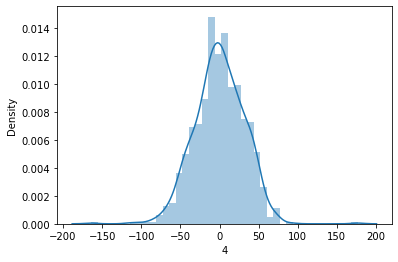

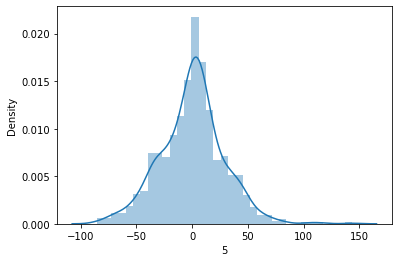

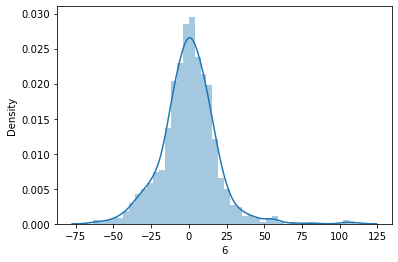

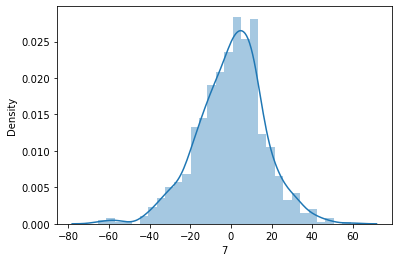

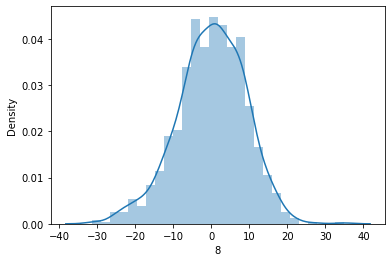

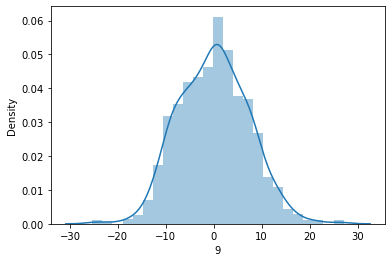

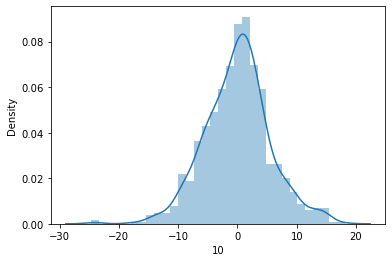

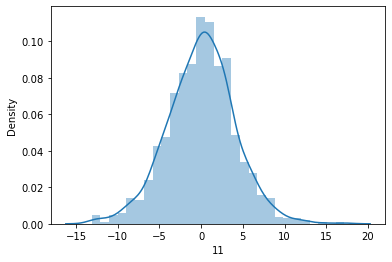

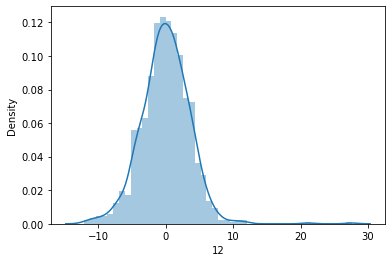

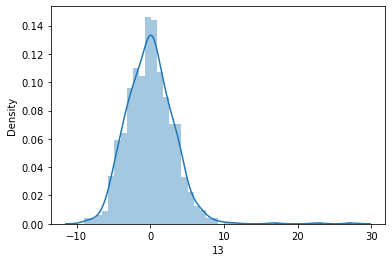

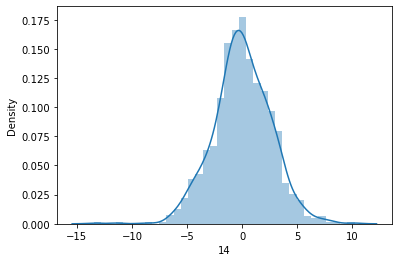

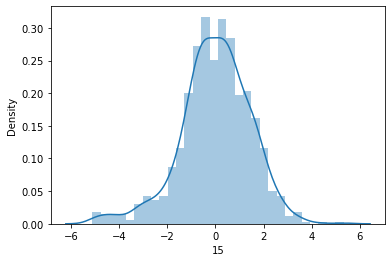

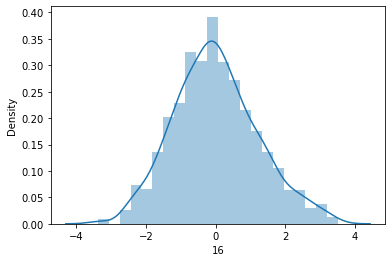

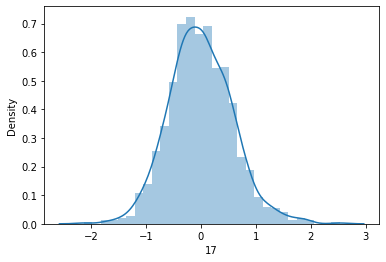

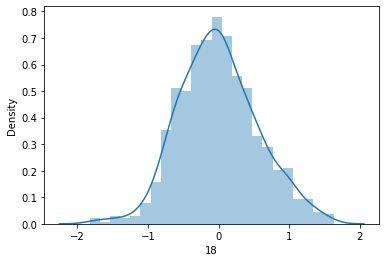

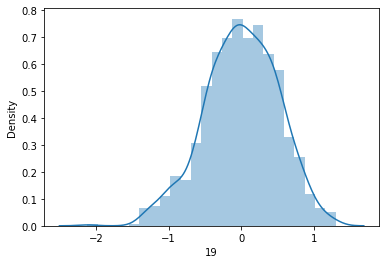

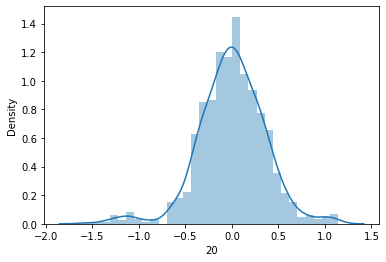

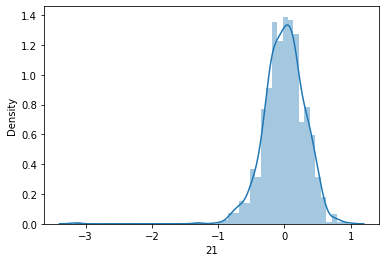

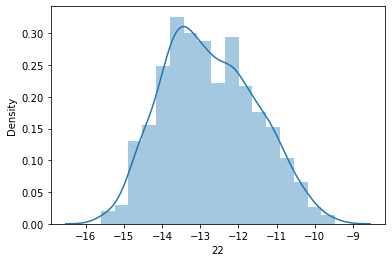

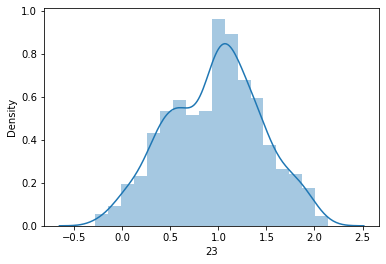

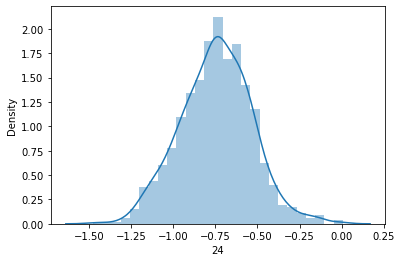

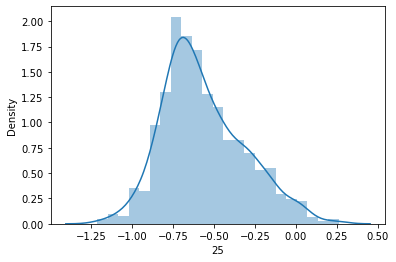

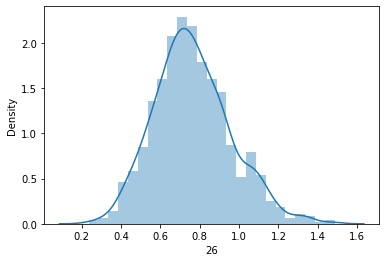

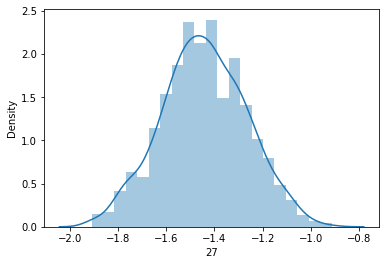

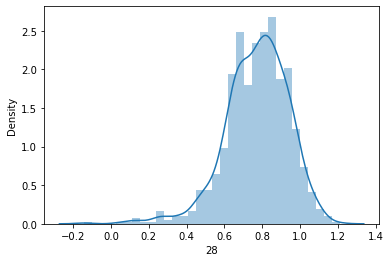

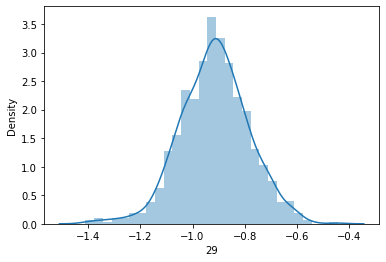

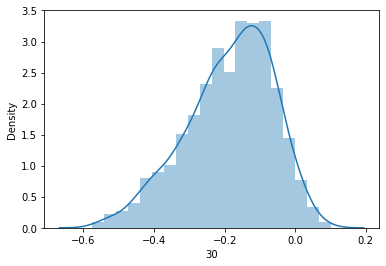

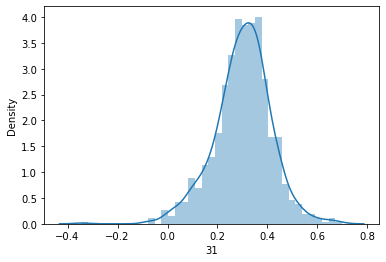

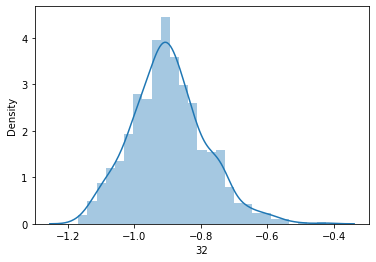

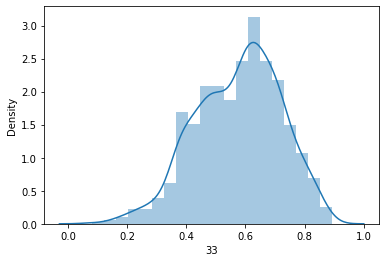

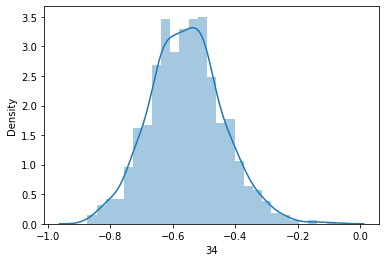

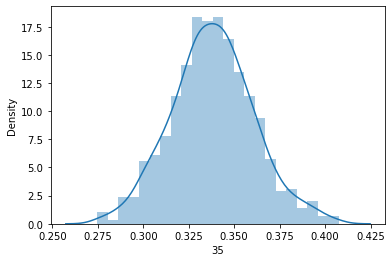

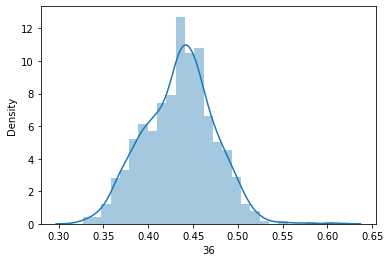

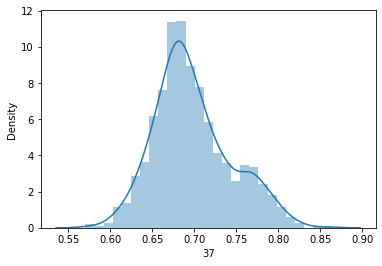

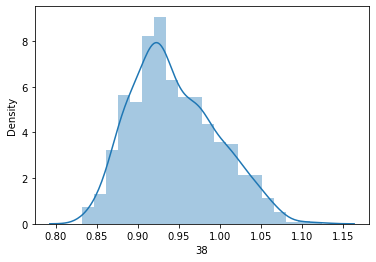

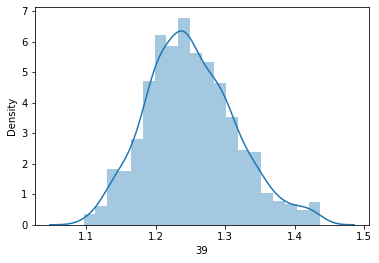

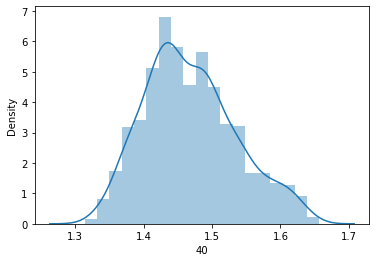

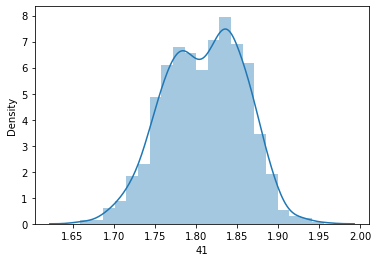

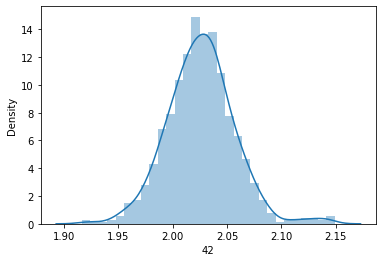

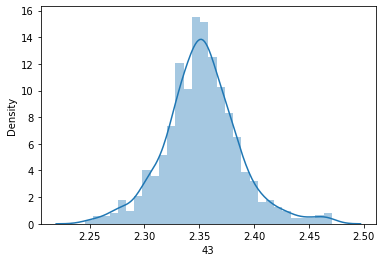

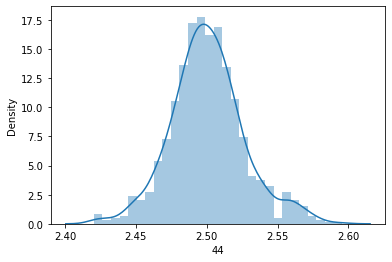

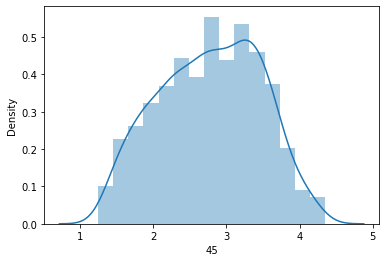

In [8]:
# function to see distribution.

def plot(df, feature):
    sns.distplot(df[feature])
    plt.show()
    
for feature in df.columns:  # seeing distribution of inputs and output
    plot(df, feature)

<AxesSubplot:>

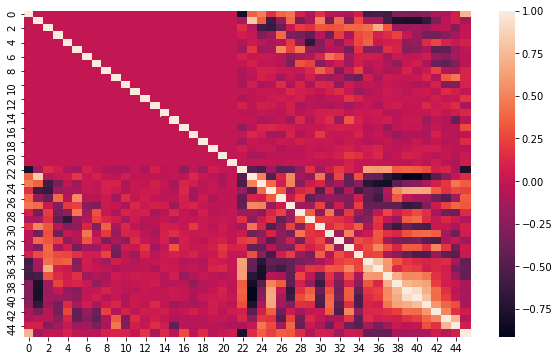

In [9]:
# Seeing correlation heatmap between inputs and outputs.

plt.figure(figsize=(10,6))

sns.heatmap(df.corr(),annot = False)

In [10]:
# Input data, i.e., speech features

inputs = df.iloc[:,:-1]
inputs.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,-444.570925,296.776581,18.202963,45.533201,1.642507,-15.425329,4.708653,46.790126,8.448926,15.889262,...,0.365777,0.453181,0.678998,0.891810,1.230811,1.421894,1.796246,1.986595,2.309713,2.508269
1,195.424383,42.548533,-47.232038,55.060092,7.180520,18.735858,13.461191,-0.250632,7.562356,2.405553,...,0.334413,0.406532,0.655776,0.960409,1.218916,1.415331,1.815550,2.011391,2.334045,2.517978
2,334.387423,-17.849127,-72.648701,82.934209,-7.990511,22.857897,9.841212,0.760615,8.922243,1.083629,...,0.323393,0.384863,0.658164,0.975786,1.247341,1.422940,1.800574,2.004081,2.318268,2.518089
3,-84.540389,105.204346,-51.079037,53.362872,-3.819920,-0.333042,7.604571,10.182099,1.337922,4.478997,...,0.341841,0.426488,0.681705,0.939973,1.236867,1.449592,1.802309,1.988633,2.341644,2.501178
4,-362.376360,236.886432,-116.752987,72.598387,42.287054,-6.337295,35.864093,8.531290,-2.272590,-5.680350,...,0.367235,0.446047,0.641988,0.941404,1.233371,1.399887,1.803749,1.989725,2.318140,2.509942


In [11]:
inputs.shape

(960, 45)

In [12]:
type(inputs)

pandas.core.frame.DataFrame

In [13]:
# Output data i.e., subjective MOS (last column)

outputs = df.iloc[:,-1:]
outputs.head()

,45
0,1.90
1,3.40
2,4.00
3,2.60
4,1.85


In [14]:
outputs.shape

(960, 1)

In [15]:
type(outputs)

pandas.core.frame.DataFrame

In [16]:
########################################### PCA starts here ############################################

In [17]:
# No need of PCA here #

In [18]:
##################################### PCA over here ####################################################

In [19]:
# Pre-processing

x = inputs.values  # converting dataframe "inputs" into array form
x 

array([[-444.5709253 ,  296.7765813 ,   18.20296278, ...,    1.98659479,
           2.30971275,    2.50826936],
       [ 195.4243833 ,   42.54853319,  -47.23203771, ...,    2.01139084,
           2.3340454 ,    2.51797832],
       [ 334.3874228 ,  -17.84912727,  -72.64870084, ...,    2.00408129,
           2.31826767,    2.51808857],
       ...,
       [-220.5627226 , -216.9397659 , -202.2839704 , ...,    2.08007023,
           2.42266332,    2.53353402],
       [ 118.1400231 , -102.5909086 , -193.9346759 , ...,    2.12108006,
           2.45645967,    2.56106166],
       [-578.3095456 , -270.3646653 , -210.0675624 , ...,    2.05751983,
           2.39908817,    2.52950057]])

In [20]:
x.shape

(960, 45)

In [21]:
y = outputs.values # converting dataframe "outputs" into array form 
y 

array([[1.9       ],
       [3.4       ],
       [4.        ],
       [2.6       ],
       [1.85      ],
       [2.95      ],
       [3.5       ],
       [2.45      ],
       [2.05      ],
       [3.25      ],
       [3.85      ],
       [2.55      ],
       [2.3       ],
       [3.05      ],
       [3.45      ],
       [2.95      ],
       [2.35      ],
       [2.8       ],
       [3.65      ],
       [2.25      ],
       [2.15      ],
       [2.95      ],
       [4.1       ],
       [2.        ],
       [1.8       ],
       [3.3       ],
       [3.75      ],
       [2.65      ],
       [2.05      ],
       [3.1       ],
       [3.6       ],
       [2.8       ],
       [2.2       ],
       [3.3       ],
       [3.8       ],
       [2.45      ],
       [1.75      ],
       [3.35      ],
       [3.45      ],
       [2.6       ],
       [2.        ],
       [2.95      ],
       [3.45      ],
       [2.95      ],
       [1.95      ],
       [2.75      ],
       [3.4       ],
       [2.65 

In [22]:
y.shape

(960, 1)

In [23]:
# Splitting data for training and testing 
# Here both x and y are in array form (non-scaled)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) 
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

# Here shuffling data is also giving same results.

In [24]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((768, 45), (192, 45), (768, 1), (192, 1))

In [25]:
# Feature Scaling # MinMaxScaler # zero mean, unit variance # range [0,1].
# Here scaling input and output both

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [26]:
x_train.shape[1] 

45

In [27]:
x.shape[1] 

45

In [28]:
y.shape[1] 

1

In [29]:
# Model developed for x => y mapping i.e, 13D MFCC, 10D LSF and 22D MRAM speech features -> subjective MOS

In [30]:
# Building neural network 

def baseline_model():
    model = Sequential()
    model.add(Dense(128, input_dim=x.shape[1], activation='relu', kernel_initializer='random_normal')) # Input layer and 1st hidden layer
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', kernel_initializer='random_normal')) # 2nd Hidden layer
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu', kernel_initializer='random_normal')) # 3rd Hidden layer
    model.add(Dropout(0.3))
    model.add(Dense(y.shape[1], activation='relu', kernel_initializer='random_normal')) # Output Layer
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mean_absolute_error']) 
    
    return model

In [31]:
m = baseline_model()

In [32]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5888      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [33]:
# To visualize DNN model

plot_model(m, to_file='SQM_model_design.pdf', show_shapes=True, show_layer_names=True)

In [34]:
# Early Stopping

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=2)

# It stops the training after 5 epochs if the validation loss doesn't improve
# Verbosity mode 0 = silent, 1 = progress bar, 2 = one line per epoch.

In [35]:
# Fitting Neural network to training set

history=m.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[early_stopping],
              batch_size=40, epochs=200) # can keep batch_size = 32 also

# verbose 0 = silent, 1 = progress bar, 2 = one line per epoch; verbose=2 is recommended.

Epoch 1/200
20/20 [==============================] - 3s 28ms/step - loss: 0.1374 - mean_absolute_error: 0.3127 - val_loss: 0.2072 - val_mean_absolute_error: 0.4010
Epoch 2/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0534 - mean_absolute_error: 0.1862 - val_loss: 0.1762 - val_mean_absolute_error: 0.3637
Epoch 3/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0355 - mean_absolute_error: 0.1507 - val_loss: 0.1484 - val_mean_absolute_error: 0.3287
Epoch 4/200
20/20 [==============================] - 0s 6ms/step - loss: 0.0330 - mean_absolute_error: 0.1442 - val_loss: 0.1295 - val_mean_absolute_error: 0.3032
Epoch 5/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0254 - mean_absolute_error: 0.1270 - val_loss: 0.1031 - val_mean_absolute_error: 0.2668
Epoch 6/200
20/20 [==============================] - 0s 6ms/step - loss: 0.0266 - mean_absolute_error: 0.1284 - val_loss: 0.0916 - val_mean_absolute_error: 0.2510
Epoch 7/200
20/20 [==

In [36]:
# To evaluate model test loss
test_loss = m.evaluate(x_test, y_test)
test_loss

6/6 [==============================] - 0s 5ms/step - loss: 0.0121 - mean_absolute_error: 0.0858


[0.012051288038492203, 0.08575930446386337]

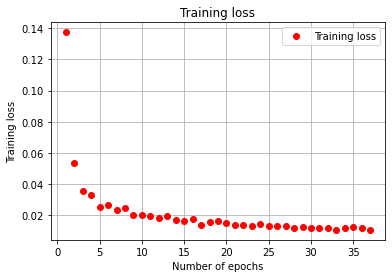

In [37]:
# To plot training loss only

loss = history.history['loss']
epochs = range(1, len(loss)+1)
plt.title('Training loss')
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# list all data (metrics) in training history

print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


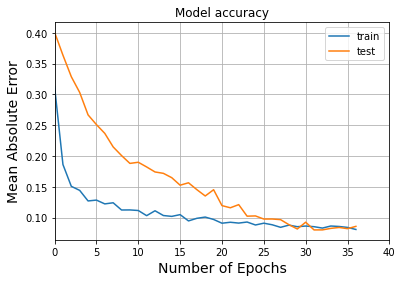

In [39]:
# To summarize history for accuracy
# Plot of accuracy on the training and validation (test) datasets over training epochs

acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']

plt.plot(acc)
plt.plot(val_acc)
plt.grid(True)
plt.title('Model accuracy')
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.xlabel('Number of Epochs', fontsize=14)
plt.legend(['train', 'test'], loc='upper right')
plt.xlim(0,40)
# plt.ylim(0,0.25)
# plt.savefig('model_accuracy.pdf', bbox_inches='tight')
plt.show()

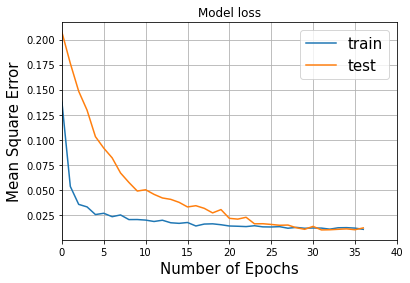

In [40]:
# To summarize history for loss
# Plot of loss on the training and validation (test) datasets over training epochs.

# plt.figure(figsize=(7, 5))
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.grid('True')
plt.title('Model loss')
plt.ylabel('Mean Square Error', fontsize=15)
plt.xlabel('Number of Epochs', fontsize=15)
plt.legend(['train', 'test'], loc='upper right', fontsize=15)
plt.xlim(0,40)
# plt.ylim(0,0.25)
# plt.text(23, 0.22, '(G)', fontsize = 20)
# plt.savefig('SQM_MRAM_MFCC_LSF_loss_plot.pdf', bbox_inches='tight')
plt.show()

In [41]:
# Making the predictions for testing

# Predicting the Test set results
y_pred = m.predict(x_test) 
# y_pred

In [42]:
y_pred.shape

(192, 1)

In [43]:
type(y_pred)

numpy.ndarray

In [44]:
# y_pred

In [45]:
# Model performance # Test error

# Measure MSE error  
mse_test = metrics.mean_squared_error(y_test, y_pred)
print("Test Mean Squared error (MSE): {}".format(mse_test))

# Measure RMSE error 
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Test Root mean squared error (RMSE): {}".format(rmse_test))

# Measure MAE error
mae_test = metrics.mean_absolute_error(y_test, y_pred)
print("Test Mean absolute error (MAE): {}".format(mae_test))

# Regression score for test 
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()
r2_score_test = metrics.r2_score(y_test_flat, y_pred_flat)
print("R2 Score Test: {}".format(r2_score_test))

Test Mean Squared error (MSE): 0.012051287583542564
Test Root mean squared error (RMSE): 0.10977835662617001
Test Mean absolute error (MAE): 0.0857593010289855
R2 Score Test: 0.7613616287287697


In [46]:
# Making the predictions for training

# Predicting the Training set results
y_pred_train = m.predict(x_train) 
y_pred_train

array([[0.44052184],
       [0.441496  ],
       [0.61182684],
       [0.40828973],
       [0.17218469],
       [0.6550976 ],
       [0.5309035 ],
       [0.6611258 ],
       [0.74611276],
       [0.17321299],
       [0.21553625],
       [0.34568512],
       [0.19161865],
       [0.38807502],
       [0.7721593 ],
       [0.24334002],
       [0.4116955 ],
       [0.19773331],
       [0.5912958 ],
       [0.5849882 ],
       [0.5021336 ],
       [0.29135925],
       [0.68872255],
       [0.15996873],
       [0.66801614],
       [0.7224651 ],
       [0.515702  ],
       [0.70531994],
       [0.6006888 ],
       [0.3243962 ],
       [0.67651004],
       [0.584875  ],
       [0.18954295],
       [0.2951494 ],
       [0.5598046 ],
       [0.5275163 ],
       [0.19219549],
       [0.480042  ],
       [0.37868005],
       [0.44503254],
       [0.14360248],
       [0.5876057 ],
       [0.26700568],
       [0.25373447],
       [0.6934008 ],
       [0.39601052],
       [0.72367007],
       [0.708

In [47]:
y_pred_train.shape 

(768, 1)

In [48]:
# Model performance # Training error

# Measure MSE error  
mse_train = metrics.mean_squared_error(y_train, y_pred_train)
print("Training Mean Squared error (MSE): {}".format(mse_train))

# Measure RMSE error 
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
print("Training Root mean squared error (RMSE): {}".format(rmse_train))

# Measure MAE error
mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
print("Training Mean absolute error (MAE): {}".format(mae_train))

# Regression score for training
y_pred_train_flat = y_pred_train.flatten()
y_train_flat = y_train.flatten()
r2_score_train = metrics.r2_score(y_train_flat, y_pred_train_flat)
print("R2 Score Train: {}".format(r2_score_train))

Training Mean Squared error (MSE): 0.007574274657343327
Training Root mean squared error (RMSE): 0.08703030884320316
Training Mean absolute error (MAE): 0.06937447510956098
R2 Score Train: 0.8475180433395306


In [49]:
####################################### Evaluating Model #######################################

In [50]:
# # Cross-validation # Training

estimator = KerasRegressor(build_fn=baseline_model, epochs=200, batch_size=40, verbose=0)
kfold = KFold(n_splits=3)
results = cross_val_score(estimator, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print("CV scores (train): {}".format(results))
print("Mean CV score (train): %.10f (%.10f)" % (results.mean(), results.std()))

CV scores (train): [-0.01156145 -0.01357045 -0.01283029]
Mean CV score (train): -0.0126540647 (0.0008295809)


In [51]:
# # Cross-validation # Testing

estimator = KerasRegressor(build_fn=baseline_model, epochs=200, batch_size=40, verbose=0)
kfold = KFold(n_splits=3)
results = cross_val_score(estimator, x_test, y_test, cv=kfold, scoring='neg_mean_squared_error')
print("CV scores (test): {}".format(results))
print("Mean CV score (test): %.10f (%.10f)" % (results.mean(), results.std()))

CV scores (test): [-0.02337775 -0.01634929 -0.01393452]
Mean CV score (test): -0.0178871869 (0.0040056228)


In [52]:
# Saving results in csv file

no_epoch = len(loss)

results = pd.DataFrame([[mse_train, mse_test, mae_train, mae_test, no_epoch]],
columns=['MSE Train', 'MSE Test', 'MAE Train', 'MAE Test', 'No_of_Epochs'])
# results.to_csv('results_SQM_DNN_MRAM_MFCC_LSF.csv')

In [53]:
results 

,MSE Train,MSE Test,MAE Train,MAE Test,No_of_Epochs
0,0.007574,0.012051,0.069374,0.085759,37


In [54]:
# m.save('SQM_DNN_MRAM.h5')

In [55]:
from platform import python_version

print(python_version())

3.8.5


### Correlation between predicted objective MOS using DNN and subjective MOS for test speech samples.

In [56]:
# Predicted objective MOS of test speech samples using DNN.

y_obj_mos = y_pred # objective MOS of test speech samples
y_obj_mos

array([[0.6664948 ],
       [0.6854506 ],
       [0.7291734 ],
       [0.23704782],
       [0.30131763],
       [0.6820274 ],
       [0.7629975 ],
       [0.35438934],
       [0.63399386],
       [0.34714073],
       [0.43798995],
       [0.5797826 ],
       [0.57241976],
       [0.49748474],
       [0.46246007],
       [0.52487355],
       [0.17459683],
       [0.3111871 ],
       [0.5254673 ],
       [0.61921763],
       [0.17668584],
       [0.3575507 ],
       [0.4896452 ],
       [0.44948682],
       [0.69966245],
       [0.36425406],
       [0.6106806 ],
       [0.37001508],
       [0.58810115],
       [0.47672328],
       [0.8193901 ],
       [0.6391357 ],
       [0.34567624],
       [0.7110809 ],
       [0.81547624],
       [0.38607907],
       [0.45803088],
       [0.47510168],
       [0.51144916],
       [0.37018287],
       [0.57424164],
       [0.20832497],
       [0.33031046],
       [0.22051819],
       [0.6971075 ],
       [0.70593196],
       [0.45041722],
       [0.575

In [57]:
len(y_obj_mos)

192

In [58]:
type(y_obj_mos)

numpy.ndarray

In [59]:
# Subjective MOS of corresponding test speech samples.

y_sub_mos = y_test # subjective MOS of test speech samples
y_sub_mos

array([[0.66129032],
       [0.66129032],
       [0.70967742],
       [0.0483871 ],
       [0.46774194],
       [0.75806452],
       [0.88709677],
       [0.29032258],
       [0.61290323],
       [0.35483871],
       [0.5       ],
       [0.62903226],
       [0.67741935],
       [0.62903226],
       [0.46774194],
       [0.40322581],
       [0.20967742],
       [0.35483871],
       [0.48387097],
       [0.61290323],
       [0.33870968],
       [0.61290323],
       [0.51612903],
       [0.46774194],
       [0.80645161],
       [0.5       ],
       [0.67741935],
       [0.37096774],
       [0.70967742],
       [0.72580645],
       [0.82258065],
       [0.67741935],
       [0.43548387],
       [0.75806452],
       [0.83870968],
       [0.46774194],
       [0.5483871 ],
       [0.48387097],
       [0.72580645],
       [0.46774194],
       [0.70967742],
       [0.08064516],
       [0.33870968],
       [0.17741935],
       [0.80645161],
       [0.67741935],
       [0.58064516],
       [0.919

In [60]:
len(y_sub_mos)

192

In [61]:
type(y_sub_mos)

numpy.ndarray

In [62]:
# Pearson correlation

pear_corr, _ = stats.pearsonr(y_sub_mos.flatten(), y_obj_mos.flatten())
pear_corr

0.8886451612505705

In [63]:
# Spearman correlation

spearman_corr, _ = stats.spearmanr(y_sub_mos.flatten(), y_obj_mos.flatten())
spearman_corr

0.8958842059678751

In [64]:
# RMSE (THIS RMSE IS TEST RMSE OF DNN MODEL)

rmse_test = np.sqrt(metrics.mean_squared_error(y_sub_mos.flatten(), y_obj_mos.flatten()))
rmse_test

0.10977835662617001

### Taking inverse to obtain actual objective MOS and subjective MOS before splitting data.

In [65]:
# Taking inverse of min-max scalar to obtain y_obj_mos_inv (real objective MOS) before splitting

y_obj_mos_inv = scaler.inverse_transform(y_pred)
y_obj_mos_inv

array([[3.316134 ],
       [3.374897 ],
       [3.5104375],
       [1.9848483],
       [2.1840847],
       [3.364285 ],
       [3.615292 ],
       [2.348607 ],
       [3.215381 ],
       [2.326136 ],
       [2.6077688],
       [3.047326 ],
       [3.024501 ],
       [2.7922027],
       [2.6836262],
       [2.8771079],
       [1.7912501],
       [2.21468  ],
       [2.8789485],
       [3.1695745],
       [1.7977262],
       [2.3584073],
       [2.7679002],
       [2.6434093],
       [3.4189534],
       [2.3791876],
       [3.1431098],
       [2.3970466],
       [3.0731134],
       [2.727842 ],
       [3.7901094],
       [3.2313206],
       [2.3215964],
       [3.4543507],
       [3.7779765],
       [2.446845 ],
       [2.6698956],
       [2.7228153],
       [2.8354924],
       [2.3975668],
       [3.030149 ],
       [1.8958073],
       [2.2739623],
       [1.9336064],
       [3.4110334],
       [3.438389 ],
       [2.6462934],
       [3.0335495],
       [3.3076117],
       [3.0953493],


In [66]:
# Taking inverse of min-max scalar to obtain y_sub_mos_inv (real subjective MOS) before splitting

y_sub_mos_inv = scaler.inverse_transform(y_test)
y_sub_mos_inv

array([[3.3 ],
       [3.3 ],
       [3.45],
       [1.4 ],
       [2.7 ],
       [3.6 ],
       [4.  ],
       [2.15],
       [3.15],
       [2.35],
       [2.8 ],
       [3.2 ],
       [3.35],
       [3.2 ],
       [2.7 ],
       [2.5 ],
       [1.9 ],
       [2.35],
       [2.75],
       [3.15],
       [2.3 ],
       [3.15],
       [2.85],
       [2.7 ],
       [3.75],
       [2.8 ],
       [3.35],
       [2.4 ],
       [3.45],
       [3.5 ],
       [3.8 ],
       [3.35],
       [2.6 ],
       [3.6 ],
       [3.85],
       [2.7 ],
       [2.95],
       [2.75],
       [3.5 ],
       [2.7 ],
       [3.45],
       [1.5 ],
       [2.3 ],
       [1.8 ],
       [3.75],
       [3.35],
       [3.05],
       [4.1 ],
       [3.9 ],
       [3.25],
       [2.35],
       [2.3 ],
       [3.1 ],
       [2.4 ],
       [1.65],
       [2.25],
       [2.15],
       [2.65],
       [4.25],
       [1.75],
       [1.4 ],
       [2.95],
       [1.85],
       [3.15],
       [2.15],
       [2.55],
       [2.

In [67]:
# Pearson correlation

pear_corr, _ = stats.pearsonr(y_sub_mos_inv.flatten(), y_obj_mos_inv.flatten())
pear_corr

0.8886451557020736

In [68]:
# Spearman correlation

spearman_corr, _ = stats.spearmanr(y_sub_mos_inv.flatten(), y_obj_mos_inv.flatten())
spearman_corr

0.8958842059678751

In [69]:
# RMSE 

rmse_test = np.sqrt(metrics.mean_squared_error(y_sub_mos_inv.flatten(), y_obj_mos_inv.flatten()))
rmse_test

0.3403129208851753

#### Note: With inverse or without taking inverse of objective and subjective MOS, the correlation value remains same.

### Scatter plot for all test speech samples

192
192


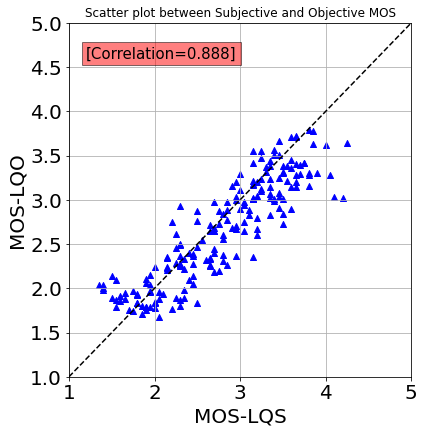

In [70]:
def plotscatter(x, y, xlabel, ylabel, xrange=(1, 5), yrange=(1, 5)):

    # blue = plt.scatter(x[0:20], y[0:20], color='b', marker='^', label='ECHO', s=100)  # s-size of marker
    # green = plt.scatter(x[20:40], y[20:40], color='g', marker='v', label='CHOP', s=100)
    # yellow = plt.scatter(x[44:58], y[44:58], color='y', marker='o', label='CLIP', s=100)
    # red = plt.scatter(x[40:50], y[40:50], color='r', marker='>', label='COMPSPKR', s=100)
    # magenta = plt.scatter(x[50:70], y[50:70], color='m', marker='<', label='NOISE', s=100)
    # magenta = plt.scatter(x, y, color='m', marker='>', label='Speech Samples', s=100)
    # magenta = plt.scatter(x, y, color='b', marker='>')
    plt.scatter(x, y, color='b', marker='^')

    # plt.legend(prop={'size': 20}, loc=4, scatterpoints=1, handles=[magenta])  # Legends
    # plt.legend(prop={'size': 20}, loc=4, scatterpoints=1, handles=[blue, green, red, magenta)  # Legends
    # plt.legend(prop={'size': 20}, loc=4, scatterpoints=1, handles=[blue, green, yellow, red, magenta])  # Legends
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.grid(axis='both')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    # plt.title(title)

obj_mos = y_obj_mos_inv  # objective mos
print(len(obj_mos))

sub_mos = y_sub_mos_inv  # subjective mos
print(len(sub_mos))

# Scatter plot
fig, ax = plt.subplots(figsize=(6, 6))  # figure size of scatter plot
plotscatter(sub_mos, obj_mos, 'MOS-LQS', 'MOS-LQO')

# Adding text inside plot
plt.text(1.2, 4.6, '[Correlation=0.888]', fontsize=15, bbox=dict(facecolor='red', alpha=0.5))

# Diagonal dashed line (k-black)
ax.plot([1, 5], [1, 5], 'k--', c='k')  # x-limit range and y-limit range
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# plt.savefig('scatter_plot_MRAM_plus_MFCC_plus_LSF_45D.pdf', bbox_inches='tight')
plt.tight_layout()
plt.title('Scatter plot between Subjective and Objective MOS')
plt.show()

In [71]:
# done